# UCL-PKU summer school, RSA session

## Load and preprocess data

In [195]:
import numpy as np
import numpy.matlib 
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression

In [196]:
bdata_tone = scipy.io.loadmat('../Data/bdata_tone')['bdata_tone'].tolist()[0]
bdata_tone = [x.reshape(-1) for x in bdata_tone]
nSubj = len(bdata_tone)
nTrial = [len(x) for x in bdata_tone]
freq = np.unique(bdata_tone[0]).astype(float)
nFreq = len(freq)

edata_tone = scipy.io.loadmat('../Data/edata_tone')['edata_tone'].tolist()[0]
nTime = 95
time = np.arange(-40, 900 + 1, 10) # in millisecond
nChan = 64

## Average across trials by frequency

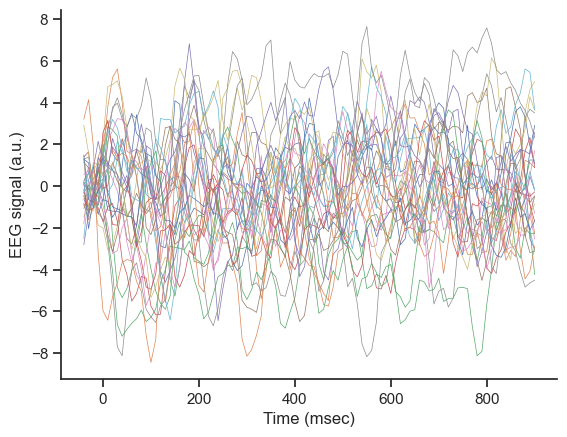

In [199]:
# Raw data check
iChan = 39
iFreq = 2
iSubj = 2
tmp = edata_tone[iSubj][bdata_tone[iSubj] == freq[iFreq], iChan, :][0:30,:].T
tmp = tmp - np.repeat(tmp[time<=0, :].mean(axis=0).reshape(1,-1), nTime, axis = 0) # baseline

plt.plot(time, tmp)
plt.xlabel('Time (msec)')
plt.ylabel('EEG signal (a.u.)')
plt.show()

In [200]:
# Initialize a 4D array to store ERP data
edata_tone_by_freq = np.full((nSubj, nFreq, nChan, nTime), fill_value=np.nan)

# Loop over each subject and frequency to compute mean ERP data
for iSubj in range(nSubj):
    for iFreq in range(nFreq):
        # cur_freq_index = np.where(bdata_tone[iSubj] == iFreq)[0]
        edata_tone_by_freq[iSubj, iFreq, :, :] = np.mean(edata_tone[iSubj][bdata_tone[iSubj] == freq[iFreq], :, :], axis=0)


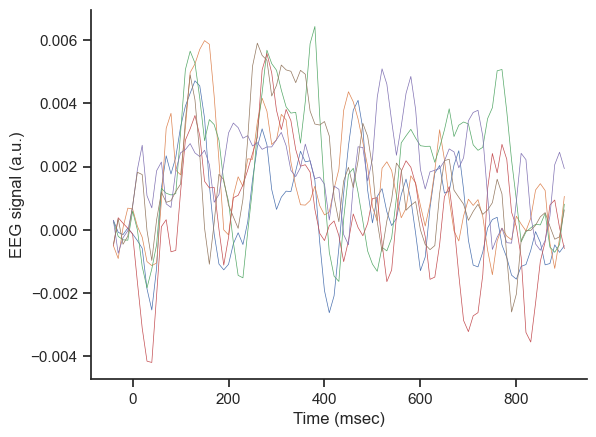

In [201]:
# A bruetal check Averaged ERP data, grand average
averaged_edata_tone_by_freq = edata_tone_by_freq.mean(axis = 2).mean(axis = 0)
averaged_edata_tone_by_freq = averaged_edata_tone_by_freq - np.repeat(averaged_edata_tone_by_freq[:, time<=0].mean(axis = 1).reshape((-1,1)), nTime, axis = 1) # baseline

plt.plot(time, averaged_edata_tone_by_freq.T)
plt.xlabel('Time (msec)')
plt.ylabel('EEG signal (a.u.)')
plt.show()

## Calculate neural RDM

In [145]:
# Initialize a 3D array to store the distance matrices
nFreqPair = int(nFreq*(nFreq-1)/2)
neural_RDM = np.full((nSubj, nTime, nFreqPair), fill_value=np.nan)

# Loop over each subject and time point to compute distance matrices
for iSubj in range(nSubj):
    for iTime in range(nTime):
        edata_iSubj_iTime = edata_tone_by_freq[iSubj, :, :, iTime]
        neural_RDM[iSubj, iTime, :] = pdist(edata_iSubj_iTime, 'euclidean')

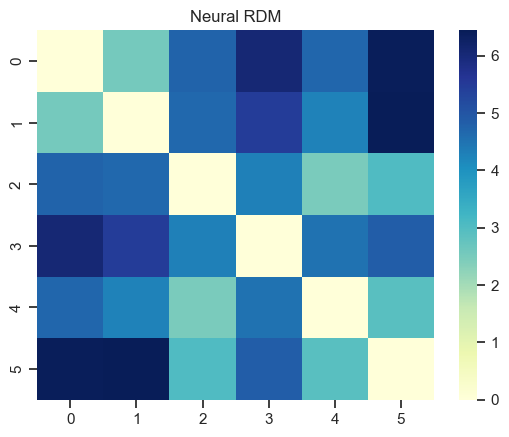

In [175]:
# check neural RDM for a participant
iTime = time == 180
iSubj = 0
sns.heatmap(squareform(neural_RDM[iSubj, iTime, :].squeeze()), cmap="YlGnBu", annot=False, cbar=True)
plt.title("Neural RDM")
# Show the plot
plt.show()

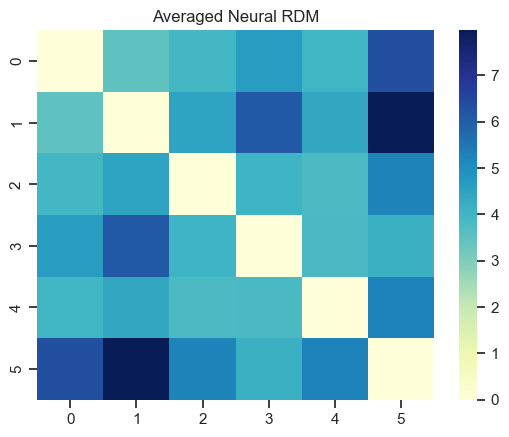

In [177]:
# check neural RDM for a participant
iTime = time == 180
sns.heatmap(squareform(neural_RDM[:, iTime, :].mean(axis = 0).squeeze()), cmap="YlGnBu", annot=False, cbar=True)
plt.title("Averaged Neural RDM")
# Show the plot
plt.show()

## Build model RDM

In [231]:
freq_lut = np.array([381, 538, 762, 1077, 1524, 2155])
freq_hz = freq_lut[(freq.astype(int) -1)]
freq_log = np.log(freq_hz)

In [232]:
model_RDM_origin = np.tril(np.abs(freq_hz[:, np.newaxis] - freq_hz), -1)
model_RDM_origin = model_RDM_origin.T.flat[model_RDM_origin.T.flat[:] !=0] # transform to vector-form

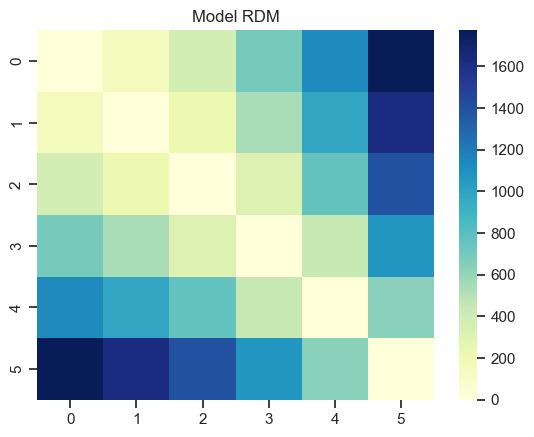

In [233]:
sns.heatmap(squareform(model_RDM_origin), cmap="YlGnBu", cbar=True) #YlGnBu
plt.title("Model RDM")
# Show the plot
plt.show()

In [234]:
freq_lut = np.array([381, 538, 762, 1077, 1524, 2155])
freq_hz = freq_lut[(freq.astype(int) -1)]
freq_log = np.log(freq_hz)

In [235]:
model_RDM_log = np.tril(np.abs(freq_log[:, np.newaxis] - freq_log), -1)
model_RDM_log = model_RDM_log.T.flat[model_RDM_log.T.flat[:] !=0] # transform to vector-form

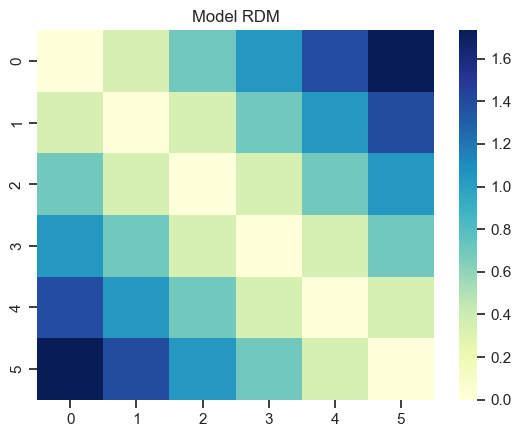

In [236]:
sns.heatmap(squareform(model_RDM_log), cmap="YlGnBu", cbar=True) #YlGnBu
plt.title("Model RDM")
# Show the plot
plt.show()

## Regress neural RDM with model RDM

In [238]:
lr = LinearRegression(fit_intercept = True)
lr.fit(zscore(model_RDM_origin).reshape((-1,1)), neural_RDM.transpose((2,0,1)).reshape(nFreqPair, -1))
beta_origin = lr.coef_.reshape(nSubj, nTime)
beta_origin_mean = beta_origin.mean(axis = 0)
beta_origin_se = beta_origin.std(axis = 0)/np.sqrt(nSubj)

In [239]:
lr = LinearRegression(fit_intercept = True)
lr.fit(zscore(model_RDM_log).reshape((-1,1)), neural_RDM.transpose((2,0,1)).reshape(nFreqPair, -1))
beta_log = lr.coef_.reshape(nSubj, nTime)
beta_log_mean = beta_log.mean(axis = 0)
beta_log_se = beta_log.std(axis = 0)/np.sqrt(nSubj)

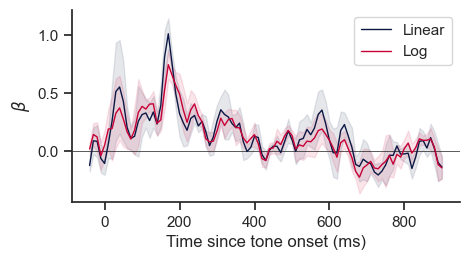

In [247]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = (5, 2.5));
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "lines.linewidth": 0.5}
sns.set_theme(style="ticks", rc=custom_params)
plt.axhline(y=0, color = 'k') 

# Plot the main line
sns.lineplot(x=time, y=beta_origin_mean, color = '#0c1844', linewidth = 1, label="Linear")
# Add the shaded error area
plt.fill_between(time, beta_origin_mean - beta_origin_se, beta_origin_mean + beta_origin_se, color = '#0c1844', alpha=0.1)

# Plot the main line
sns.lineplot(x=time, y=beta_log_mean, color = '#c80036', linewidth = 1, label="Log")
plt.fill_between(time, beta_log_mean - beta_log_se, beta_log_mean + beta_log_se, color = '#c80036', alpha=0.1)


# Customize the plot
plt.xlabel('Time since tone onset (ms)')
plt.ylabel(r'$\beta$')

# Show the plot
plt.show()

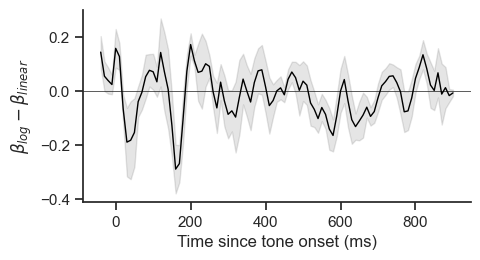

In [251]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = (5, 2.5));
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "lines.linewidth": 0.5}
sns.set_theme(style="ticks", rc=custom_params)
plt.axhline(y=0, color = 'k') 

beta_diff = beta_log - beta_origin
beta_diff_mean = beta_diff.mean(axis = 0)
beta_diff_se = beta_diff.std(axis = 0)/np.sqrt(nSubj)

# Plot the main line
sns.lineplot(x=time, y=beta_diff_mean, color = 'black', linewidth = 1)
# Add the shaded error area
plt.fill_between(time, beta_diff_mean - beta_diff_se, beta_diff_mean + beta_diff_se, color = 'black', alpha=0.1)

# Customize the plot
plt.xlabel('Time since tone onset (ms)')
plt.ylabel(r'$\beta_{log} - \beta_{linear}$')

# Show the plot
plt.show()